In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heat
%pylab inline
%load_ext autoreload  
%autoreload 2
from scipy import ndimage
#from scipy.interpolate import interpn
#from transformations import *  # handy set of rotation routines!!!!


Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams.update({'font.size': 20})

In [3]:
# make a file name for code outputs, can be used to make heat file names too
def nodefilename(froot,suffix,index):
    num1 = '{0:d}'.format(index)
    ff = froot + '_'
    if (index < 100000):
        ff = ff + '0'
    if (index < 10000):
        ff = ff + '0'
    if (index < 1000):
        ff = ff + '0'
    if (index < 100):
        ff = ff + '0'
    if (index < 10):
        ff = ff + '0'
    ff = ff + num1 + suffix
    print(ff)
    return ff

# for testing
#froot = '../heat_s18/a1'; suffix = '_node.txt'
#nfile = nodefilename(froot,suffix,6)
#print(nfile); #../heat_s18/a1_000006_node.txt


In [39]:
# return a meshgrid and linspaces and actual spacing dx_actual
def mkgrid(dx,xmax):
    #dy = dx
    xmin = -xmax;
    ymax = xmax; ymin = -ymax;
    nx = np.int((xmax-xmin)/dx) + 1;
    ny = nx
    xlinsp = np.linspace(xmin,xmax,nx)
    ylinsp = np.linspace(ymin,ymax,ny)
    yarrh,xarrh = np.meshgrid(ylinsp,xlinsp)  #nontrivial order here, is flipped
    #xarrh[i,*] gives x depending on i and is all the same for second index
    dx_actual = xlinsp[1]- xlinsp[0]  # dx is not exact
    return dx_actual,xlinsp,yarrh,xarrh

# lat lon grids
def mklatlongrid(dphi):  # returns phigrid [-pi,pi], thetagrid [-pi/2,pi/2]
    phimin = -np.pi
    phimax =  np.pi
    thetamin = -np.pi/2.
    thetamax =  np.pi/2.
    nth  = int((thetamax - thetamin)/dphi) + 1
    nphi = int((phimax   - phimin)  /dphi) + 1
    philinsp = np.linspace(phimin,phimax,nphi)
    thetalinsp = np.linspace(thetamin,thetamax,nth)
    parrh,tarrh = np.meshgrid(philinsp,thetalinsp)  # x,y but indexing is j,i
    return thetalinsp,philinsp,tarrh,parrh

#thetalinsp,philinsp,tarrh,parrh = mklatlongrid(0.1) test

# lat lon grids
def mkmulongrid(dphi):  # returns phigrid [-pi,pi], thetagrid [-pi/2,pi/2]
    phimin = -np.pi
    phimax =  np.pi
    mumin = -1.0  # is sin theta
    mumax =  1.0
    nphi = int((phimax - phimin)/dphi) + 1
    nmu  = int(nphi/2)
    philinsp = np.linspace(phimin,phimax,nphi)
    mulinsp = np.linspace(mumin,mumax,nmu)
    parrh,marrh = np.meshgrid(philinsp,mulinsp)  # x,y but indexing is j,i
    return mulinsp,philinsp,marrh,parrh

In [43]:
#   passing xarr,yarr,zarr coordinate arrays
#   heat array is harr
#   summing those within a distance of midplane 
#   use Gaussian weighting as a function of distance from plane
#   binning uses dx and xmax to make grid
# integral of  e^-x^2 is sqrt pi
def heatxysig(xarr,yarr,zarr,harr,dx,xmax,sigz,nrand):
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)    # grid
    pixarea =  dx_actual**2; 
    mhist = xarrh*0.0;
    mrhist = xarrh*0.0;
    whist = xarrh*0.0;
    poff = 0.0;  # pixel offset
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    fac = 1.0/np.sqrt(2.0*np.pi) * (1.0/sigz) # for normalization of z part
    fac = fac/nrand/pixarea
    n = np.size(xarr);
    for i in range (0,n):  # loop over particles
        if (np.abs(zarr[i]) < 3*sigz):
            for k in range(nrand):
                xg = xarr[i] 
                yg = yarr[i] 
                zg = zarr[i] 
                if (nrand >1):
                    xg += np.random.normal(0.0,dx_actual/2)
                    yg += np.random.normal(0.0,dx_actual/2)
                    zg += np.random.normal(0.0,dx_actual/2) 
                zg2 = 0.5*(zg/sigz)**2  # is positive
                weight = np.exp(-zg2) # gaussian weight
                xi = np.int((xg - np.min(xlinsp))/dx_actual + poff);
                yi = np.int((yg - np.min(xlinsp))/dx_actual + poff);
                if ((xi >=0) and (xi<np.size(xlinsp))):
                    if ((yi >=0) and (yi<np.size(xlinsp))):
                        mhist[xi,yi]+= weight*harr[i]  # sumk with weights via z
                        mrhist[xi,yi]+= weight*harr[i]*rarr[i]  # T*r
                        #checked order!
                        whist[xi,yi]+= weight; 
    mhist = mhist*fac  # normalize heat/volume                    
    #jj = np.where(whist >0.0)
    #mhist[jj] = mhist[jj]/whist[jj]
    #mhist = mhist/whist
    #mrhist = mrhist/whist
    return xarrh,yarrh,mhist,mrhist   # note order

# trying to make a lat lon heatmap
def latlon_heat(xarr,yarr,zarr,harr,dphi,rmin,sigd,nrand):
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    phiarr = np.arctan2(yarr,xarr)  
    jj = np.where(phiarr>np.pi)
    phiarr[jj] -= 2.0*np.pi
    latarr = np.arcsin(zarr/rarr)   
    dphi_actual = philinsp[1]-philinsp[0]
    dtheta_actual = thetalinsp[1]-thetalinsp[0]
    hhist = tarrh*0.0
    n = np.size(xarr);
    nrand_ac = nrand
    if (nrand<1):
        nrand_ac=1
    for i in range (0,n):  # loop over particles
        for j in range(0,nrand_ac):
            x = xarr[i] + np.random.normal(0.0,sigd)
            y = yarr[i] + np.random.normal(0.0,sigd)
            z = zarr[i] + np.random.normal(0.0,sigd)
            rr = np.sqrt(x*x + y*y + z*z)
            theta = np.arcsin(z/rr) # latitude [-pi/2,pi/2]
            phi = np.arctan2(y,x) # longitude [-pi,pi]
            if (phi >= np.pi):
                phi -= 2.0*np.pi
            ip = int((phi - np.min(philinsp))/dphi_actual)
            it = int((theta - np.min(thetalinsp))/dtheta_actual)
            if (((rr > rmin) and (ip>=0)) and (it >=0)):
                hhist[it,ip] += harr[i]/nrand_ac  # yx indexing
    nnp = np.size(philinsp)
    nnt = np.size(thetalinsp)
    hhist[:,nnp-1] = hhist[:,0]
    hhist[nnt-1,:] = hhist[0,:]
    # now probably should multiply each pixel by its area?
    # do we want heat per unit area?
    #muarrh = np.cos(tarrh) + np.cos(np.pi/2 - dtheta_actual)
    area = thetalinsp*0.0
    for i in range(0,nnt-1):
        area[i] = ( np.sin(thetalinsp[i+1]) - np.sin(thetalinsp[i]) )*dphi_actual
    area[nnt-1] = area[0]
    #print(area)
    for j in range(0,nnp):
        hhist[:,j] /= area
    return tarrh,parrh,hhist



In [111]:
def plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,ofile):
    suffix = '_heat.txt'
    if (di<=0):
        print("plt_heat_ll: di<=0!!! no data")
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    hsum = parrh*0.0
    for i in range(0,di):
        nfile = nodefilename(froot,suffix,index+i)
        iarr,xarr,yarr,zarr,dedt,xrot,yrot = \
            np.loadtxt(nfile, skiprows=2, unpack=True)
        tarrh,parrh,hhist=latlon_heat(xrot,yrot,zarr,dedt,dphi,rmin,sigd,nrand)
        hsum += hhist/di
    return hsum

def plt_heat_ll(hsum,froot,index,di,dphi,rmin,sigd,nrand,nsmo,ofile):
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    f, axarr = plt.subplots(1,1,sharex=True,sharey=True,figsize=(8.5,5));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.13)
    f.subplots_adjust(right=0.85)
    f.subplots_adjust(bottom=0.15)
    f.subplots_adjust(top=0.95)
    axarr.set_xlabel('longitude')
    axarr.set_ylabel('latitude')
    axarr.set_yticks([-np.pi/2,0,np.pi/2])
    axarr.set_yticklabels([r'-$\pi$/2','0',r'$\pi$/2'], minor=False)
    axarr.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    axarr.set_xticklabels([r'-$\pi$',r'-$\pi$/2','0',r'$\pi$/2',r'$\pi$'], minor=False)
    
    img = ndimage.gaussian_filter(hsum,[nsmo,2*nsmo])
    ave_all = np.mean(img)
    imgshow= img/ave_all
    max_all = np.max(np.max(imgshow))
    min_all = np.min(np.min(imgshow))
    
    imgp=axarr.pcolormesh(parrh,tarrh,imgshow,vmin=min_all,vmax=max_all,cmap='plasma')
    
    dlev = 0.1
    levmax = dlev*int(max_all/dlev)
    levmin = dlev*int(min_all/dlev)
    levels = np.arange(levmin, levmax, dlev)
    #print(levels)
    CS = axarr.contour(parrh,tarrh,imgshow, levels,colors='white')
   
    ii = np.argmin( np.fabs(levels - 1.0))
    #print(ii)
    shortlev = (levels[ii],levels[ii+2])
    #print(shortlev)
    axarr.clabel(CS, shortlev, inline=1, fmt='%1.1f', fontsize=14) #
    
    cbar_ax = f.add_axes([0.860, 0.17, 0.03, 0.68])
    f.colorbar(imgp, cax=cbar_ax,format='%.1f')
    f.colorbar(CS, cax=cbar_ax,format='%.1f')
    
    if (len(ofile)>2):
        plt.savefig(ofile)
        
def plt3_heat(froot,index,di,dx,sigz,multr,xmax,nsmo,ofile):
    nrand=1
    #nsmo =0.5
    suffix = '_heat.txt'
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)   
    mhist_a = 0*xarrh
    mhist_b = 0*xarrh
    mhist_c = 0*xarrh
    if (di==0):
        print("plt3_heat: di==0!!! no data")
    for i in range(0,di):
        nfile = nodefilename(froot,suffix,index+i)
        iarr,xarr,yarr,zarr,dedt,xrot,yrot = \
            np.loadtxt(nfile, skiprows=2, unpack=True)
        xarrh_a,yarrh_a,mhist_ai,mrhist_a  = heatxysig(xrot,yrot,zarr,dedt,dx,xmax,sigz,nrand)
        xarrh_b,zarrh_b,mhist_bi,mrhist_b  = heatxysig(xrot,zarr,yrot,dedt,dx,xmax,sigz,nrand)
        yarrh_c,zarrh_c,mhist_ci,mrhist_c  = heatxysig(yrot,zarr,xrot,dedt,dx,xmax,sigz,nrand)
        mhist_a += mhist_ai
        mhist_b += mhist_bi
        mhist_c += mhist_ci
    if (di >0):
        mhist_a /= di
        mhist_b /= di
        mhist_c /= di
        
    #rarr0=np.sqrt(xarr0**2 + yarr0**2 + zarr0**2)
    
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.80)

    plt.setp([a.get_xticklabels() for a in f.axes], visible=False) ;
    plt.setp([a.get_yticklabels() for a in f.axes], visible=False) ;
    plt.setp(axarr[0].get_xticklabels(), visible=True) ;
    plt.setp(axarr[0].get_yticklabels(), visible=True) ;
    axarr[0].set_xlim([-xmax,xmax])
    axarr[0].set_ylim([-xmax,xmax])
    for i in range(0,3):
        axarr[i].set_aspect(1.0);
        axarr[i].set_adjustable('box-forced')

    img_a = ndimage.gaussian_filter(mhist_a,nsmo)
    img_b = ndimage.gaussian_filter(mhist_b,nsmo)
    img_c = ndimage.gaussian_filter(mhist_c,nsmo)
    max_all = np.max([np.max(img_a),np.max(img_b), np.max(img_c)])
    img=axarr[0].pcolormesh(xarrh_a,yarrh_a,img_a,vmin=0,vmax=max_all,cmap='inferno')
    img=axarr[1].pcolormesh(xarrh_a,yarrh_a,img_b,vmin=0,vmax=max_all,cmap='inferno')
    img=axarr[2].pcolormesh(xarrh_a,yarrh_a,img_c,vmin=0,vmax=max_all,cmap='inferno')
    
    for i in range(0,3):
        axarr[i].plot((0),(0),'r+')

    cbar_ax = f.add_axes([0.81, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    d1=0.07; v1=0.05;
    d2=0.07; v2=0.09;
    pm = xmax;
    xyzcolor='lightgreen'
    axarr[0].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[0].text(-pm+d2, pm-v2,'y',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[1].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[1].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[2].text( pm-d1,-pm+v1,'y',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[2].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    
    if (len(ofile) > 2):
        plt.savefig(ofile)



In [11]:
# for all simulations
xmax = 1.1
sigz = 0.20
dx = 0.08
nsmo=1

../moon_heat/m2_out/m2_000045_heat.txt
../moon_heat/m2_out/m2_000046_heat.txt
../moon_heat/m2_out/m2_000047_heat.txt
../moon_heat/m2_out/m2_000048_heat.txt
../moon_heat/m2_out/m2_000049_heat.txt
../moon_heat/m2_out/m2_000050_heat.txt
../moon_heat/m2_out/m2_000051_heat.txt
../moon_heat/m2_out/m2_000052_heat.txt
../moon_heat/m2_out/m2_000053_heat.txt
../moon_heat/m2_out/m2_000054_heat.txt


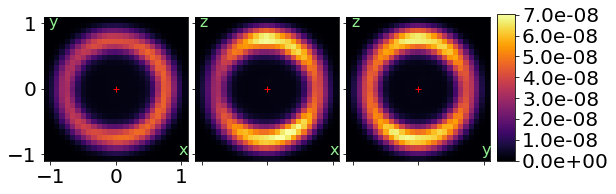

In [103]:
froot = '../moon_heat/m2_out/m2'; 
index=45
plt3_heat(froot,index,10,dx,sigz,0,xmax,1,'m2heatxyz.png')

In [59]:
froot = '../moon_heat/m2_out/m2'; 
index=30
di=10       # number of code outputs to use
dphi=0.1    # approx pixel size in phi in radians
rmin=0.5    # discard points within this radius
nsmo=1.0    # some smoothing
sigd=0.1    # add some random offsets in particle positions
nrand=2     # how many random offsets
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'')


../moon_heat/m2_out/m2_000030_heat.txt
../moon_heat/m2_out/m2_000031_heat.txt
../moon_heat/m2_out/m2_000032_heat.txt
../moon_heat/m2_out/m2_000033_heat.txt
../moon_heat/m2_out/m2_000034_heat.txt
../moon_heat/m2_out/m2_000035_heat.txt
../moon_heat/m2_out/m2_000036_heat.txt
../moon_heat/m2_out/m2_000037_heat.txt
../moon_heat/m2_out/m2_000038_heat.txt
../moon_heat/m2_out/m2_000039_heat.txt


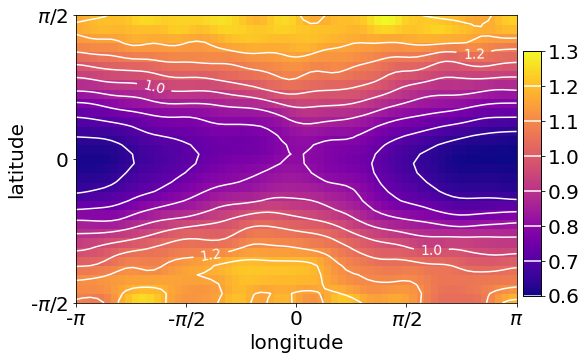

In [115]:
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo,'m2_ll.png')

../moon_heat/m3_out/m3_000050_heat.txt
../moon_heat/m3_out/m3_000051_heat.txt
../moon_heat/m3_out/m3_000052_heat.txt
../moon_heat/m3_out/m3_000053_heat.txt
../moon_heat/m3_out/m3_000054_heat.txt
../moon_heat/m3_out/m3_000055_heat.txt
../moon_heat/m3_out/m3_000056_heat.txt
../moon_heat/m3_out/m3_000057_heat.txt
../moon_heat/m3_out/m3_000058_heat.txt
../moon_heat/m3_out/m3_000059_heat.txt


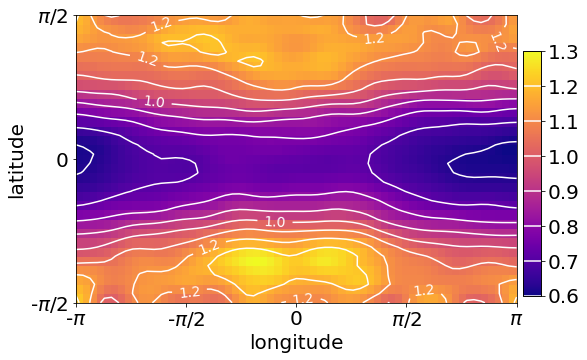

In [114]:
froot = '../moon_heat/m3_out/m3'; 
index=50
di=10       # number of code outputs to use
dphi=0.1    # approx pixel size in phi in radians
rmin=0.5    # discard points within this radius
nsmo=1.0    # some smoothing
sigd=0.1    # add some random offsets in particle positions
nrand=2     # how many random offsets
img_m3=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'')
plt_heat_ll(img_m3,froot,index,di,dphi,rmin,sigd,nrand,nsmo,'m3_ll.png')


../moon_heat/m4_out/m4_000060_heat.txt
../moon_heat/m4_out/m4_000061_heat.txt
../moon_heat/m4_out/m4_000062_heat.txt
../moon_heat/m4_out/m4_000063_heat.txt
../moon_heat/m4_out/m4_000064_heat.txt
../moon_heat/m4_out/m4_000065_heat.txt
../moon_heat/m4_out/m4_000066_heat.txt
../moon_heat/m4_out/m4_000067_heat.txt
../moon_heat/m4_out/m4_000068_heat.txt
../moon_heat/m4_out/m4_000069_heat.txt


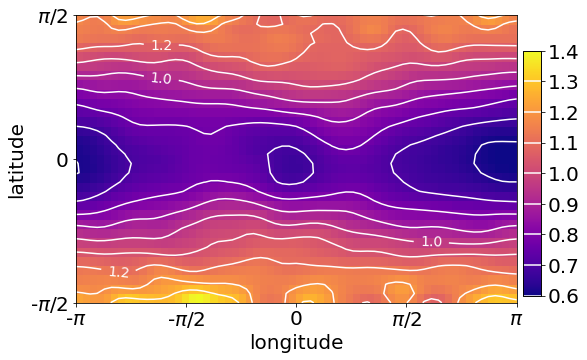

In [116]:
froot = '../moon_heat/m4_out/m4'; 
index=60
di=10       # number of code outputs to use
dphi=0.1    # approx pixel size in phi in radians
rmin=0.5    # discard points within this radius
nsmo=1.0    # some smoothing
sigd=0.1    # add some random offsets in particle positions
nrand=2     # how many random offsets
img_m3=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'')
plt_heat_ll(img_m3,froot,index,di,dphi,rmin,sigd,nrand,nsmo,'m4_ll.png')


../moon_heat/m1_out/m1_000030_heat.txt
../moon_heat/m1_out/m1_000031_heat.txt
../moon_heat/m1_out/m1_000032_heat.txt
../moon_heat/m1_out/m1_000033_heat.txt
../moon_heat/m1_out/m1_000034_heat.txt
../moon_heat/m1_out/m1_000035_heat.txt
../moon_heat/m1_out/m1_000036_heat.txt
../moon_heat/m1_out/m1_000037_heat.txt
../moon_heat/m1_out/m1_000038_heat.txt
../moon_heat/m1_out/m1_000039_heat.txt


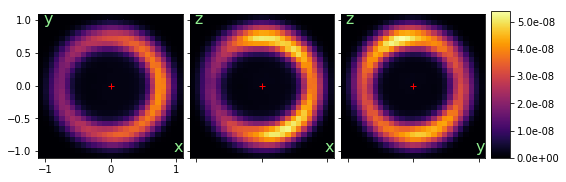

In [36]:
froot = '../moon_heat/m1_out/m1'; 
index=30
plt3_heat(froot,index,10,dx,sigz,0,xmax,1,'m1heatxyz.png')


../moon_heat/m1_out/m1_000030_heat.txt
../moon_heat/m1_out/m1_000031_heat.txt
../moon_heat/m1_out/m1_000032_heat.txt
../moon_heat/m1_out/m1_000033_heat.txt
../moon_heat/m1_out/m1_000034_heat.txt
../moon_heat/m1_out/m1_000035_heat.txt
../moon_heat/m1_out/m1_000036_heat.txt
../moon_heat/m1_out/m1_000037_heat.txt
../moon_heat/m1_out/m1_000038_heat.txt
../moon_heat/m1_out/m1_000039_heat.txt


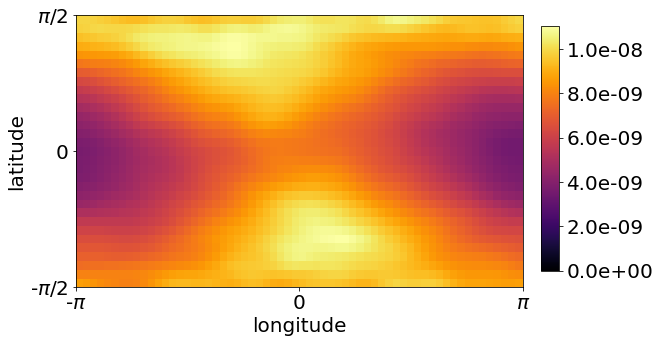

In [48]:
froot = '../moon_heat/m1_out/m1'; 
index=30
di=10     # number of outputs to use
dphi=0.1  # approx pixel size in phi in radians
rmin=0.5  # discard points within this radius
nsmo=1.0  # some smoothing
sigd=0.1  # random offsets in particle distn (more smoothing)
nrand=3  # number of randoms
plt_heat_ll(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'m1_ll.png')
# has bad area!

In [9]:
def plt_tarr(froot,index):
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.82)
    suffix = '_node.txt'
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = np.loadtxt(nfile, skiprows=2, unpack=True)
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2); 
    jj1 = np.where((np.fabs(zarr)<0.2) & (xarr>0) & (np.fabs(yarr)<0.2))
    jj2 = np.where((np.fabs(zarr)<0.2) & (xarr<0) & (np.fabs(yarr)<0.2))
    jj3 = np.where((np.fabs(yarr)<0.2) & (np.fabs(xarr)<0.2))
    jj4 = np.where((np.fabs(yarr)<0.2) & (np.fabs(zarr)<0.2))
    axarr[0].plot(rarr[jj1],tarr[jj1],'r.',ms=1)
    axarr[0].plot(rarr[jj2],tarr[jj2],'b.',ms=1)
    axarr[1].plot(rarr[jj3],tarr[jj3],'g.',ms=1)
    axarr[1].plot(rarr[jj4],tarr[jj4],'m.',ms=1)
    
    
def plt_dedt(froot,index):
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.82)
    suffix = '_heat.txt'
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,dedt,ang1,ang2 = np.loadtxt(nfile, skiprows=2, unpack=True)
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2); 
    jj1 = np.where((np.fabs(zarr)<0.2) & (xarr>0) & (np.fabs(yarr)<0.2))
    jj2 = np.where((np.fabs(zarr)<0.2) & (xarr<0) & (np.fabs(yarr)<0.2))
    jj3 = np.where((np.fabs(yarr)<0.2) & (np.fabs(xarr)<0.2))
    jj4 = np.where((np.fabs(yarr)<0.2) & (np.fabs(zarr)<0.2))
    axarr[0].plot(rarr[jj1],dedt[jj1],'r.',ms=1)
    axarr[0].plot(rarr[jj2],dedt[jj2],'b.',ms=1)
    axarr[1].plot(rarr[jj3],dedt[jj3],'g.',ms=1)
    axarr[1].plot(rarr[jj4],dedt[jj4],'m.',ms=1)

In [6]:
#   passing xarr,yarr,zarr coordinate arrays
#   temperature array is tarr
#   averaging those within a distance of midplane 
#   use Gaussian weighting as a function of distance from plane
#   binning uses dx and xmax to make grid
def tempxysig(xarr,yarr,zarr,tarr,dx,xmax,sigz,nrand):
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)  # grid
    mhist = xarrh*0.0;
    mrhist = xarrh*0.0;
    whist = xarrh*0.0;
    poff = 0.0;  # pixel offset
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    n = np.size(xarr);
    for i in range (0,n):  # loop over particles
        if (np.abs(zarr[i]) < 3*sigz):
            for k in range(nrand):
                xg = xarr[i] 
                yg = yarr[i] 
                zg = zarr[i] 
                if (nrand >1):
                    xg += np.random.normal(0.0,dx_actual/2)
                    yg += np.random.normal(0.0,dx_actual/2)
                    zg += np.random.normal(0.0,dx_actual/2) 
                weight = np.exp(-0.5*(zg/sigz)**2) # gaussian weight
                xi = np.int((xg - np.min(xlinsp))/dx_actual + poff);
                yi = np.int((yg - np.min(xlinsp))/dx_actual + poff);
                if ((xi >=0) and (xi<np.size(xlinsp))):
                    if ((yi >=0) and (yi<np.size(xlinsp))):
                        mhist[xi,yi]+= weight*tarr[i]  # averaging with weights via z
                        mrhist[xi,yi]+= weight*tarr[i]*rarr[i]  # T*r
                        #checked order!
                        whist[xi,yi]+= weight; 
                        
    jj = np.where(whist >0.0)
    mhist[jj] = mhist[jj]/whist[jj]
    #mhist = mhist/whist
    mrhist = mrhist/whist
    return xarrh,yarrh,mhist,mrhist   # note order



In [7]:
def plt_temp(froot,index,dx,sigz,xmax,vmax):
    suffix = '_node.txt'
    nfile0 = nodefilename(froot,suffix,0)
    iarr,xarr0,yarr0,zarr0,vxarr,vyarr,vzarr,tarr,cv,surf = np.loadtxt(nfile0, skiprows=2, unpack=True)
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf = np.loadtxt(nfile, skiprows=2, unpack=True)
    #xmax = 1.1
    #dx = 0.10
    #sigz = 0.15
    xarrh,yarrh,mhist,mrhist  = tempxysig(xarr0,yarr0,zarr0,tarr,dx,xmax,sigz)
    f, axarr = plt.subplots(1,1,sharex=True,sharey=True,figsize=(8.5,6));
    img=axarr.pcolormesh(xarrh,yarrh,mhist,vmin=0,vmax=vmax,cmap='inferno')
    axarr.set_aspect(1.0);
    cbar_ax = f.add_axes([0.830, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    
def plt3_temp(froot,index,dx,sigz,multr,xmax,nsmo):
    nrand=3
    #nsmo =0.5
    suffix = '_node.txt'
    nfile0 = nodefilename(froot,suffix,0)
    iarr,xarr0,yarr0,zarr0,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = \
        np.loadtxt(nfile0, skiprows=2, unpack=True)
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = \
        np.loadtxt(nfile, skiprows=2, unpack=True)
    xarrh_a,yarrh_a,mhist_a,mrhist_a  = tempxysig(xarr0,yarr0,zarr0,tarr,dx,xmax,sigz,nrand)
    xarrh_b,zarrh_b,mhist_b,mrhist_b  = tempxysig(xarr0,zarr0,yarr0,tarr,dx,xmax,sigz,nrand)
    yarrh_c,zarrh_c,mhist_c,mrhist_c  = tempxysig(yarr0,zarr0,xarr0,tarr,dx,xmax,sigz,nrand)
    rarr0=np.sqrt(xarr0**2 + yarr0**2 + zarr0**2)
    
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.80)
    #plt.axis('tight');
    x1 = xarrh_a
    #plt.axis([x1.min(), x1.max(), x1.min(), x1.max()]);
    plt.setp([a.get_xticklabels() for a in f.axes], visible=False) ;
    plt.setp([a.get_yticklabels() for a in f.axes], visible=False) ;
    plt.setp(axarr[0].get_xticklabels(), visible=True) ;
    plt.setp(axarr[0].get_yticklabels(), visible=True) ;
    axarr[0].set_xlim([-xmax,xmax])
    axarr[0].set_ylim([-xmax,xmax])
    for i in range(0,3):
        axarr[i].set_aspect(1.0);
        axarr[i].set_adjustable('box-forced')
    
    lmin=-5
    lmax=0
    llev = np.linspace(lmin,lmax,(lmax-lmin)*3+1)
    levels = 10.0**llev
    if (multr==1):
        rarrh = np.sqrt(xarrh_a**2 + yarrh_a**2)
        max_all = np.max(tarr*rarr0)
        #img=axarr[0].pcolormesh(xarrh_a,yarrh_a,mhist_a*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        #img=axarr[1].pcolormesh(xarrh_b,zarrh_b,mhist_b*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        #img=axarr[2].pcolormesh(yarrh_c,zarrh_c,mhist_c*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[0].pcolormesh(xarrh_a,yarrh_a,mrhist_a,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[1].pcolormesh(xarrh_b,zarrh_b,mrhist_b,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[2].pcolormesh(yarrh_c,zarrh_c,mrhist_c,vmin=0,vmax=max_all,cmap='inferno')
    else:
        img_a = ndimage.gaussian_filter(mhist_a,nsmo)
        img_b = ndimage.gaussian_filter(mhist_b,nsmo)
        img_c = ndimage.gaussian_filter(mhist_c,nsmo)
        max_all = np.max(img_a)
        img=axarr[0].pcolormesh(xarrh_a,yarrh_a,img_a,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[1].pcolormesh(xarrh_b,zarrh_b,img_b,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[2].pcolormesh(yarrh_c,zarrh_c,img_c,vmin=0,vmax=max_all,cmap='inferno')
        #levels = (1e-3,1e-2,1e-1)
        col= 'cyan'
        dx_actual = xarrh_a[1][1] - xarrh_a[0][0]
        print(dx_actual)
        xc_a = xarrh_a[:-1, :-1] + dx_actual/2.
        yc_a = yarrh_a[:-1, :-1] + dx_actual/2.
        xc_b = xarrh_b[:-1, :-1] + dx_actual/2.
        zc_b = zarrh_b[:-1, :-1] + dx_actual/2.
        yc_c = yarrh_c[:-1, :-1] + dx_actual/2.
        zc_c = zarrh_c[:-1, :-1] + dx_actual/2.
        cs = axarr[0].contour(xc_a,yc_a,mhist_a[:-1, :-1],levels,colors=col)
        cs = axarr[1].contour(xc_b,zc_b,mhist_b[:-1, :-1],levels,colors=col)
        cs = axarr[2].contour(yc_c,zc_c,mhist_c[:-1, :-1],levels,colors=col)
        axarr[0].plot((0),(0),'k+')
        axarr[1].plot((0),(0),'k+')
        axarr[2].plot((0),(0),'k+')

    cbar_ax = f.add_axes([0.830, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    d1=0.07; v1=0.05;
    d2=0.07; v2=0.09;
    pm = x1.max();
    xyzcolor='lightgreen'
    axarr[0].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[0].text(-pm+d2, pm-v2,'y',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[1].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[1].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[2].text( pm-d1,-pm+v1,'y',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[2].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    #    plt.savefig(fname);




In [10]:
# extract the time from the top of the _node file or _heat file dependent on suffix
def extract_time(froot,index,suffix):
    #froot = '../moon_heat/n1_out/n1'; 
    #index = 5
    #suffix = '_heat.txt'
    nfile = nodefilename(froot,suffix,index)
    infile = open(nfile, 'r')
    firstLine = infile.readline()
    #print(firstLine)
    time_a = np.fromstring(firstLine[1:], dtype=double, sep=' ')
    time = time_a[0]
    #print(time)
    infile.close()
    return time

    
# tests
#froot = '../moon_heat/n1_out/n1'
#index=5
#suffix = '_heat.txt'
#time = extract_time(froot,index,suffix)
#print(time)